In [1]:
import rasterio
from shapely.geometry import box
import geopandas as gpd
import os
from dotenv import load_dotenv
from blackmarble.raster import bm_raster
import pandas as pd
import re
from datetime import datetime
import numpy as np
import rasterio
from rasterio.windows import Window, bounds as window_bounds, from_bounds
from shapely.geometry import box
import geopandas as gpd
import xarray as xr


# An environment variable can obfuscate to secure a secret
load_dotenv()
 
bearer = os.getenv("BLACKMARBLE_TOKEN")

tif_path = "../data/sdgsat/KX10_GIU_20211110_E121.18_N30.06_202200120796_L4A/KX10_GIU_20211110_E121.18_N30.06_202200120796_L4A_A_LH.tif"

# Open the file
with rasterio.open(tif_path) as src:
    bounds = src.bounds  # left, bottom, right, top
    crs = src.crs
    transform  = src.transform       # ←‑‑‑ add this line

# Create a polygon geometry of the extent
bbox = box(*bounds)

# Turn it into a GeoDataFrame with correct CRS
gdf = gpd.GeoDataFrame({"geometry": [bbox]}, crs=crs)

# Optional: reproject to WGS84 (lat/lon), required by blackmarblepy
gdf = gdf.to_crs("EPSG:4326")

In [2]:
def get_blackmarble(bearer, tif_path, gdf):
    # --- Extract date from tif_path ---
    # Assumes a pattern like "..._20211110_..."
    match = re.search(r"_20\d{6}_", tif_path)
    if not match:
        raise ValueError(f"Could not find date in path: {tif_path}")
    
    date_str = match.group(0).strip("_")  # "20211110"
    date = datetime.strptime(date_str, "%Y%m%d")

    # Define date range to match SDGSAT image
    date_range = pd.date_range(date, date)

    # Extract VIIRS BlackMarble daily NTL raster
    ntl_df = bm_raster(
        gdf,
        product_id="VNP46A2",  # Daily NTL product
        date_range=date_range,
        bearer=bearer,
    )

    return ntl_df

In [3]:
ntl_df = get_blackmarble(bearer, tif_path, gdf)
ntl_df["Gap_Filled_DNB_BRDF-Corrected_NTL"] = ntl_df["Gap_Filled_DNB_BRDF-Corrected_NTL"].rio.write_crs("EPSG:4326")


OBTAINING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading (15.6 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

PROCESSING TASKS | Downloading (15.6 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

COLLECTING RESULTS | Downloading (15.6 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

ValueError: Received an HTML response, which likely indicates an invalid or expired NASA Earthdata token.
Please visit https://urs.earthdata.nasa.gov/profile to verify that your token is valid and not expired.

In [9]:
def extract_sdgsat_patch_from_viirs_coords(
    ntl_df,
    viirs_band_name: str,
    tif_path: str,
    viirs_time: str,
    row: int,
    col: int,
    patch_size: int = 32
):
    """
    Given row, col pixel coordinates in the VIIRS raster, extract corresponding SDGSAT patch.
    
    Returns:
        viirs_patch: xarray DataArray (32x32 pixels)
        sdgsat_patch: np.ndarray (depends on SDGSAT resolution)
        patch_gdf_viirs: GeoDataFrame in EPSG:4326
        patch_gdf_sdgsat: GeoDataFrame in SDGSAT CRS
    """
    
    # Extract VIIRS CRS and transform
    viirs_rio = ntl_df[viirs_band_name].rio
    viirs_crs = viirs_rio.crs
    viirs_transform = viirs_rio.transform()
    
    # Construct window and get bounds
    window = Window(col_off=col, row_off=row, width=patch_size, height=patch_size)
    left, bottom, right, top = window_bounds(window, viirs_transform)
    
    # Create patch geometry in VIIRS CRS (EPSG:4326)
    patch_geom_viirs = box(left, bottom, right, top)
    patch_gdf_viirs = gpd.GeoDataFrame({"geometry": [patch_geom_viirs]}, crs=viirs_crs)

    # Clip VIIRS patch
    viirs_patch = ntl_df[viirs_band_name].sel(time=viirs_time).rio.clip(
        patch_gdf_viirs.geometry, patch_gdf_viirs.crs, drop=True
    )

    # Open SDGSAT raster
    with rasterio.open(tif_path) as src:
        sdgsat_crs = src.crs
        # Reproject VIIRS patch geometry to SDGSAT CRS
        patch_gdf_sdgsat = patch_gdf_viirs.to_crs(sdgsat_crs)
        patch_bounds_sdgsat = patch_gdf_sdgsat.total_bounds  # xmin, ymin, xmax, ymax
        
        # Clip SDGSAT patch
        window_sdgsat = from_bounds(*patch_bounds_sdgsat, transform=src.transform)
        print(window_sdgsat)
        sdgsat_patch = src.read(1, window=window_sdgsat)
        window_transform = src.window_transform(window_sdgsat)

    
    return viirs_patch, sdgsat_patch, window_transform


In [10]:
# Select random window inside VIIRS raster
viirs_rio = ntl_df["Gap_Filled_DNB_BRDF-Corrected_NTL"].rio
viirs_width, viirs_height = viirs_rio.width, viirs_rio.height

patch_size = 32
col = np.random.randint(0, viirs_width - patch_size)
row = np.random.randint(0, viirs_height - patch_size)

# Run extraction
viirs_patch, sdgsat_patch, window_transform = extract_sdgsat_patch_from_viirs_coords(
    ntl_df,
    viirs_band_name="Gap_Filled_DNB_BRDF-Corrected_NTL",
    tif_path=tif_path,
    viirs_time="2021-11-10",
    row=row,
    col=col,
    patch_size=patch_size
)

Window(col_off=np.float64(6936.339843069531), row_off=np.float64(31889.420961890137), width=np.float64(1340.715645470278), height=np.float64(1511.0955069189658))


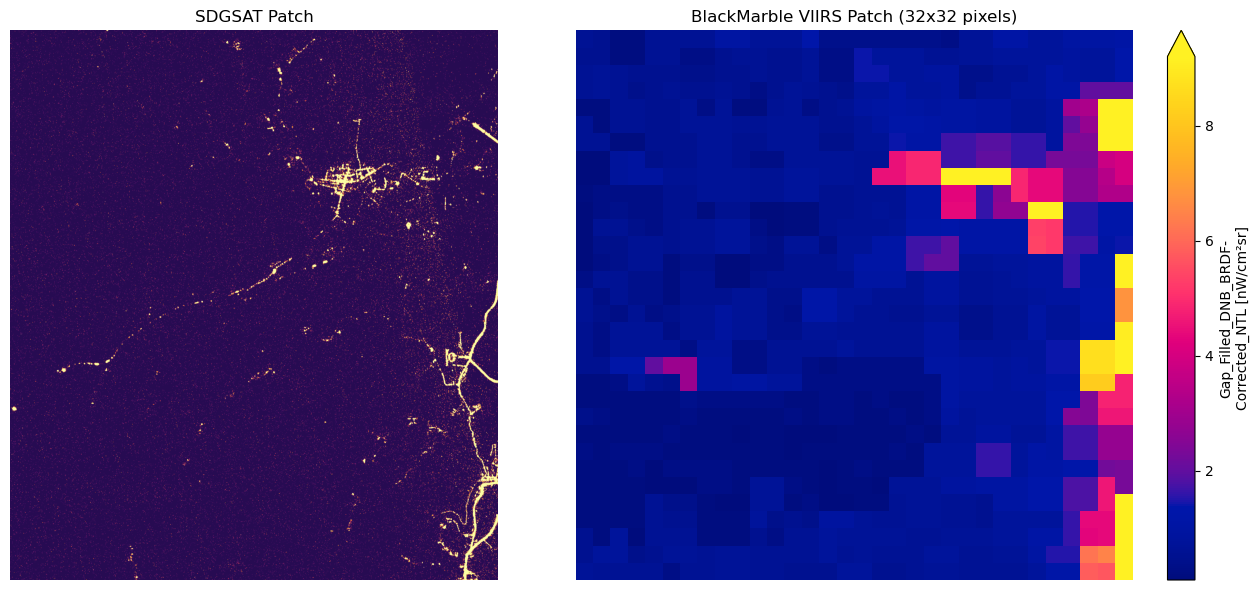

VIIRS patch shape: (32, 32)
SDGSAT patch shape: (1511, 1341)
| 10.00, 0.00, 199761.88|
| 0.00,-10.00, 3185093.32|
| 0.00, 0.00, 1.00|


In [11]:
# Plot
import matplotlib.pyplot as plt
import colorcet as cc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

valid_vals = sdgsat_patch[sdgsat_patch > 0]
vmax = np.percentile(valid_vals, 99) if valid_vals.size > 0 else 1

ax1.imshow(sdgsat_patch, cmap="inferno", vmin=0, vmax=vmax)
ax1.set_title("SDGSAT Patch")
ax1.axis("off")

viirs_patch.plot.pcolormesh(ax=ax2, cmap=cc.cm.bmy, robust=True)
ax2.set_title("BlackMarble VIIRS Patch (32x32 pixels)")
ax2.axis("off")

plt.tight_layout()
plt.show()

print("VIIRS patch shape:", viirs_patch.shape)
print("SDGSAT patch shape:", sdgsat_patch.shape)
print(window_transform)

In [12]:
from rasterio.enums import Resampling

# --- Convert SDGSAT patch to xarray with coordinates ---
ny, nx = sdgsat_patch.shape
x_coords = np.arange(nx) * window_transform.a + window_transform.c
y_coords = np.arange(ny) * window_transform.e + window_transform.f

sdgsat_xr = xr.DataArray(
    sdgsat_patch,
    coords={"y": y_coords, "x": x_coords},
    dims=["y", "x"],
    name="SDGSAT"
)
sdgsat_xr.rio.write_crs(crs, inplace=True)
sdgsat_xr.rio.write_transform(window_transform, inplace=True)

# --- Reproject SDGSAT to EPSG:4326 and match VIIRS resolution ---
sdgsat_reprojected = sdgsat_xr.rio.reproject("EPSG:4326")
sdgsat_matched = sdgsat_reprojected.rio.reproject_match(
    viirs_patch,
    resampling=Resampling.average  # .average .bilinear, .nearest, .sum etc.
)


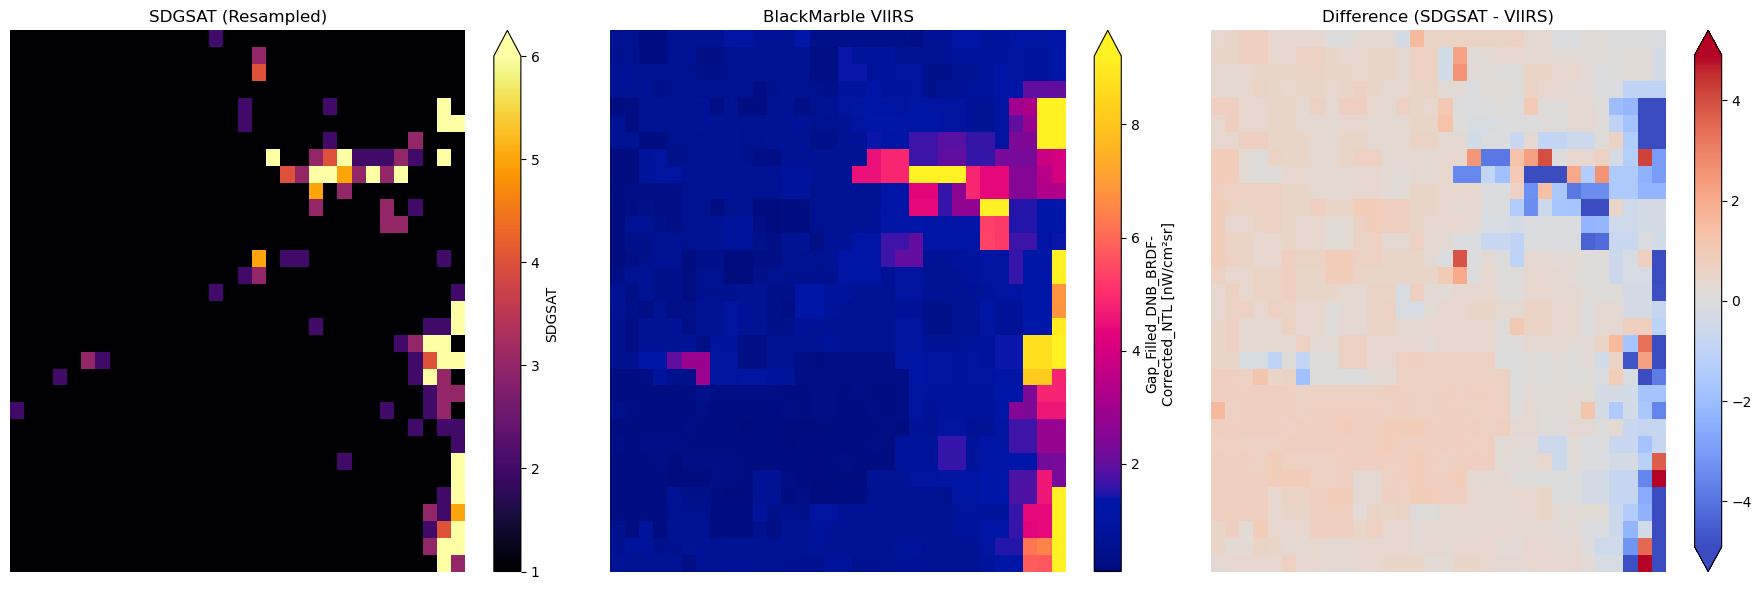

In [13]:
# --- Compute difference ---
difference = sdgsat_matched - viirs_patch

# --- Plot: SDGSAT (coarsened), VIIRS, Difference ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sdgsat_matched.plot(ax=ax1, cmap="inferno", robust=True)
ax1.set_title("SDGSAT (Resampled)")
ax1.axis("off")

viirs_patch.plot(ax=ax2, cmap=cc.cm.bmy, robust=True)
ax2.set_title("BlackMarble VIIRS")
ax2.axis("off")

difference.plot(ax=ax3, cmap="coolwarm", center=0, robust=True)
ax3.set_title("Difference (SDGSAT - VIIRS)")
ax3.axis("off")

plt.tight_layout()
plt.show()
